<a href="https://colab.research.google.com/github/indiegolab/nlp_class/blob/master/%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98_with_RNN(191202).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Copyright 2018 The TensorFlow Authors.

# 텍스트 분류 with RNN
Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

이번 텍스트 분류 실습에서는 RNN을 활용하여 ‘IMDB large movie review dataset for sentiment analysis’ 데이터에 적용해보자.  
IMDB 데이터셋은 http://ai.stanford.edu/~amaas/data/sentiment/ 에서 다운로드 받을 수 있다.


## 설정

In [1]:
# 텐서플로 2.0을 import한다.
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
# tensorflow 버전 확인
!pip show tensorflow

Name: tensorflow
Version: 2.0.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-2.0.0/python3.6
Requires: termcolor, tensorflow-estimator, absl-py, astor, protobuf, opt-einsum, keras-applications, six, tensorboard, wheel, gast, google-pasta, grpcio, wrapt, numpy, keras-preprocessing
Required-by: stable-baselines, magenta, fancyimpute


matplotlib를 가져오고 그래프를 그리는 helper 함수를 만든다

In [0]:
# history를 바탕으로 plot 그래프 그리기 함수 작성
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## 인풋 파이프라인 설정

IMDB 영화 리뷰 데이터셋: 이진분류, 모든 리뷰에는 긍정/부정 레이블이 달려있다.

- TFDS(TensorFlow Datasets) 모듈을 통해 데이터 다운로드: https://www.tensorflow.org/datasets


In [0]:
# TF 데이터셋 보기
!pip install -q tensorflow tensorflow-datasets matplotlib

In [0]:
# !pip install tensorflow==2.0.0-alpha0

In [0]:
# 기본 세팅
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds # 텐서플로 데이터셋

In [7]:
# TFDS를 통해 imdb 리뷰 데이터 가져오기

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
# train, test 데이터 할당
train_dataset, test_dataset = dataset['train'], dataset['test']

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


 데이터셋의 `info`는 인코더를 포함한다. (`tfds.features.text.SubwordTextEncoder`).

In [0]:
encoder = info.features['text'].encoder

In [9]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


이 텍스트 인코더는 문자열을 되돌릴 수 있게 인코딩하여 필요한 경우 바이트 인코딩으로 돌아갈 수 있다.

In [10]:
# 텍스트 인코더 예시, 문자열을 인덱스 숫자로 바꾼다.
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [0]:
assert original_string == sample_string

In [12]:
# 각 인덱스와 함께 디코딩하면서 각 문자열이 할당된 인덱스를 보여줌.
for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## 훈련을 위한 데이터 준비

다음 이러한 인코딩된 문자열 묶음을 만들어 낸다.
'padded_batch'를 사용하여 배치에서 가장 긴 문자열 길이로 시퀀스를 제로패딩한다.

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## 모델 생성

`tf.keras.Sequential` 모델을 생성하고 임베딩 레이어로 시작한다. 임베딩 레이어는 단어 당 하나의 벡터를 저장한다. 호출되면 단어 인덱스 시퀀스를 벡터 시퀀스로 변환한다. 이 벡터는 훈련 가능하다. 충분한 데이터로  훈련 후, 비슷한 의미를 가진 단어는 주로 비슷한 벡터를 갖는다.


이 인덱스 조회(index-lookup)는 one-hot 인코딩 된 벡터를 `tf.keras.layers.Dense` 레이어를 통해 전달하는 작업보다 훨씬 효율적이다.


RNN(Recurrent Neural Network)은 그 요소들을 반복하여 시퀀스 입력을 처리한다. RNN은 출력을 한 타임스텝에서 입력으로 전달한 다음, 다음 단계로 전달한다.


`tf.keras.layers.Bidirectional` wrapper도 RNN 레이어와 함께 사용할 수 있다. 이는 RNN 계층을 통해 입력을 앞뒤로 전파 한 다음 출력을 연결한다. 이는 RNN이 장거리 종속성(Long range dependencies)을 학습하는 데 도움이 된다.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Keras 모델을 컴파일하여 훈련 프로세스를 구성하자:

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 모델 훈련
Train the model
* history기능 사용
    - 매 에폭 마다의 훈련 손실값 (loss)
    - 매 에폭 마다의 훈련 정확도 (acc)
    - 매 에폭 마다의 검증 손실값 (val_loss)
    - 매 에폭 마다의 검증 정확도 (val_acc)

- 로그의 수치들은 학습이 제대로 되고 있는 지, 학습을 그만할 지 등을 판단하는 중요한 기준이 된다.

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 136s 349ms/step - loss: 0.6384 - accuracy: 0.6004 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 126s 321ms/step - loss: 0.3317 - accuracy: 0.8665 - val_loss: 0.3267 - val_accuracy: 0.8641
Epoch 3/10
391/391 [==============================] - 127s 324ms/step - loss: 0.2436 - accuracy: 0.9103 - val_loss: 0.3227 - val_accuracy: 0.8703
Epoch 4/10
391/391 [==============================] - 126s 323ms/step - loss: 0.2052 - accuracy: 0.9264 - val_loss: 0.3205 - val_accuracy: 0.8776
Epoch 5/10
391/391 [==============================] - 126s 322ms/step - loss: 0.1823 - accuracy: 0.9374 - val_loss: 0.3460 - val_accuracy: 0.8510
Epoch 6/10
391/391 [==============================] - 126s 323ms/step - loss: 0.1598 - accuracy: 0.9460 - val_loss: 0.3514 - val_accuracy: 0.8693
Epoch 7/10
391/391 [==============================] - 126s 322ms/step - loss: 0.1439 - accuracy: 0.9521 - val_loss: 

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 46s 119ms/step - loss: 0.4340 - accuracy: 0.8525
Test Loss: 0.43396500111235986
Test Accuracy: 0.8525199890136719


위의 모델은 시퀀스에 적용된 패딩을 가리지(mask) 않는다.  
패딩된 시퀀스를 학습하고 패딩되지 않은 시퀀스를 테스트하면 왜곡 될 수 있다.  
이상적으로는 이를 피하기 위해 마스킹(keras/masking_and_padding)을 사용하지만, 아래에서 볼 수 있듯이 출력에는 작은 영향만 미친다.

- 예측값이 >= 0.5이면 '긍정'이고 그렇지 않으면 '부정'이다.



In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [21]:
# 패딩없이 샘플 텍스트 예측

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
# sample_pred_text = ('The movie was cool. The animation and the graphics '
#                     'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.54004246]]


In [22]:
# 패딩 적용하고 샘플 텍스트 예측
## 패딩 적용시 예측값이 조금 올라가는 것을 확인할 수 있다.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.5534449]]


- 그래프를 통해 보면 훈련 정확도/손실과 검증 정확도/손실의 차이를 더 직관적으로 볼 수 있다.

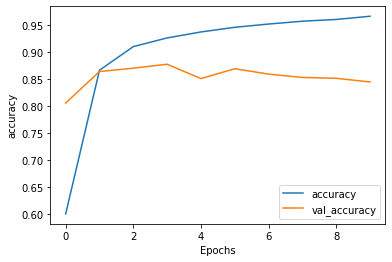

In [23]:
# 정확도
plot_graphs(history, 'accuracy')

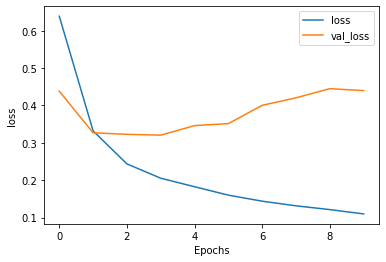

In [24]:
# 손실
plot_graphs(history, 'loss')

## 2개 혹은 그 이상의 LSTM 층 쌓기

Keras 순환 레이어에는 `return_sequences` 생성자 인수로 제어되는 두 가지 모드가 있다.

* 각 타임 스텝 (`(batch_size, timesteps, output_features)` 3D 텐서)에 대한 전체 연속 출력 시퀀스를 반환한다.
* 각 입력 시퀀스에 대한 마지막 출력만 반환한다. (2D 텐서 (batch_size, output_features)).

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 103s 263ms/step - loss: 0.6970 - accuracy: 0.5339 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 97s 248ms/step - loss: 0.6860 - accuracy: 0.5443 - val_loss: 0.7262 - val_accuracy: 0.4901
Epoch 3/10
391/391 [==============================] - 97s 247ms/step - loss: 0.6343 - accuracy: 0.6445 - val_loss: 0.6886 - val_accuracy: 0.6042
Epoch 4/10
391/391 [==============================] - 96s 246ms/step - loss: 0.5699 - accuracy: 0.7250 - val_loss: 0.5587 - val_accuracy: 0.7245
Epoch 5/10
391/391 [==============================] - 97s 247ms/step - loss: 0.5191 - accuracy: 0.7708 - val_loss: 0.5209 - val_accuracy: 0.7568
Epoch 6/10
391/391 [==============================] - 97s 247ms/step - loss: 0.4511 - accuracy: 0.8193 - val_loss: 0.5351 - val_accuracy: 0.7417
Epoch 7/10
391/391 [==============================] - 98s 250ms/step - loss: 0.4145 - accuracy: 0.8340 - val_loss: 0.4524

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 38s 97ms/step - loss: 0.5416 - accuracy: 0.7444
Test Loss: 0.5416223622496475
Test Accuracy: 0.7443600296974182


In [0]:
# # 패딩없이 샘플 텍스트 예측

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.41338694]]


In [0]:
# 패딩 적용하고 샘플 텍스트 예측

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.48886552]]


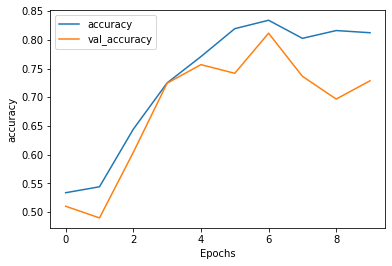

In [0]:
plot_graphs(history, 'accuracy')

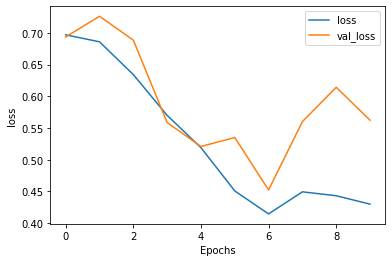

In [0]:
plot_graphs(history, 'loss')